# YOLOv8m Segmentação com CBAM - Notebook de Treinamento Completo


In [9]:
# YOLOv8m Segmentação com CBAM - Notebook de Treinamento Completo
# ================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageDraw
import os
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

## 1. Definindo modelo YOLOv8 + CBAM 

In [10]:
# YOLOv8m Segmentação com CBAM integrado manualmente
# ----------------------------------------------------
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))


class CBAM(nn.Module):
    def __init__(self, in_planes):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x) * x
        x = self.spatial_attention(x) * x
        return x


# YOLOv8-style Backbone Blocks
# ----------------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, k, s, p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.SiLU()
        )
    def forward(self, x):
        return self.conv(x)


class C2f_CBAM(nn.Module):
    def __init__(self, in_ch, out_ch, n=3):
        super().__init__()
        self.conv1 = ConvBlock(in_ch, out_ch, k=1, s=1, p=0)
        self.blocks = nn.Sequential(*[ConvBlock(out_ch, out_ch) for _ in range(n)])
        self.cbam = CBAM(out_ch * (n + 1))
        self.conv2 = ConvBlock(out_ch * (n + 1), out_ch, k=1, s=1, p=0)

    def forward(self, x):
        x1 = self.conv1(x)
        xs = [x1]
        for block in self.blocks:
            x1 = block(x1)
            xs.append(x1)
        out = torch.cat(xs, dim=1)
        out = self.cbam(out)
        return self.conv2(out)


# Mini SPPF (como no YOLOv8)
class SPPF(nn.Module):
    def __init__(self, in_ch, out_ch, k=5):
        super().__init__()
        self.conv1 = ConvBlock(in_ch, out_ch, k=1, p=0)
        self.pool = nn.MaxPool2d(kernel_size=k, stride=1, padding=k//2)
        self.conv2 = ConvBlock(out_ch * 4, out_ch, k=1, p=0)

    def forward(self, x):
        x = self.conv1(x)
        y1 = self.pool(x)
        y2 = self.pool(y1)
        y3 = self.pool(y2)
        out = torch.cat([x, y1, y2, y3], dim=1)
        return self.conv2(out)


# Simplified YOLOv8 Backbone with CBAM
# ----------------------------------------------------
class YOLOv8_CBAM_Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = ConvBlock(3, 64, k=3, s=2)
        self.layer1 = C2f_CBAM(64, 128, n=2)
        self.layer2 = C2f_CBAM(128, 256, n=3)
        self.layer3 = C2f_CBAM(256, 512, n=3)
        self.sppf = SPPF(512, 512)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.sppf(x)
        return x


# Head para Segmentação
class SegmentationHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, 2),  # 128 → 256
            nn.ReLU(),
            nn.ConvTranspose2d(256, 1, 1),       # sem mudar resolução
        )

    def forward(self, x):
        return torch.sigmoid(self.up(x))  # segmentação binária


# Modelo Final: YOLOv8m-CBAM Segmentação
# ----------------------------------------------------
class YOLOv8_CBAM_Segmentation(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = YOLOv8_CBAM_Backbone()
        self.head = SegmentationHead()

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x


## 2. Dataset para Segmentação com Máscaras (YOLO format .txt -> polígono)


In [11]:
# 2. Dataset baseado em crops com máscara PNG
# -------------------------------------------
class CropSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size

        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform_img = T.ToTensor()
        self.transform_mask = T.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        name = os.path.basename(img_path).replace(".png", "")
        mask_path = os.path.join(self.mask_dir, f"{name}_mask.png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.transform_img(image)
        mask = self.transform_mask(mask)
        mask = (mask > 0).float()  # binarizar

        return image, mask

In [12]:
# 2. Dataset para Segmentação com Máscaras (YOLO format .txt -> polígono)
# ----------------------------------------------------------------------
'''
class YoloSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, img_size=512):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.label_paths = [os.path.join(label_dir, os.path.basename(p).replace('.jpg', '.txt')) for p in self.img_paths]
        self.img_size = img_size
        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        w, h = img.size
        mask = Image.new("L", (w, h), 0)

        if os.path.exists(self.label_paths[idx]):
            with open(self.label_paths[idx], 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        coords = list(map(float, parts[1:]))
                        xy = [(coords[i]*w, coords[i+1]*h) for i in range(0, len(coords), 2)]
                        ImageDraw.Draw(mask).polygon(xy, outline=1, fill=1)

        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask
        '''

'\nclass YoloSegmentationDataset(torch.utils.data.Dataset):\n    def __init__(self, image_dir, label_dir, img_size=512):\n        self.image_dir = image_dir\n        self.label_dir = label_dir\n        self.img_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(\'.jpg\')])\n        self.label_paths = [os.path.join(label_dir, os.path.basename(p).replace(\'.jpg\', \'.txt\')) for p in self.img_paths]\n        self.img_size = img_size\n        self.transform = T.Compose([\n            T.Resize((img_size, img_size)),\n            T.ToTensor()\n        ])\n\n    def __len__(self):\n        return len(self.img_paths)\n\n    def __getitem__(self, idx):\n        img = Image.open(self.img_paths[idx]).convert("RGB")\n        w, h = img.size\n        mask = Image.new("L", (w, h), 0)\n\n        if os.path.exists(self.label_paths[idx]):\n            with open(self.label_paths[idx], \'r\') as f:\n                for line in f:\n                    parts = line.str

## 3. Funções de Perda e Métrica


In [13]:
# 3. Funções de Perda e Métrica
# -----------------------------
def dice_loss(pred, target, smooth=1.):
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    bce = F.binary_cross_entropy(pred, target)
    dsc = dice_loss(pred, target)
    return bce + dsc

def miou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * target).sum((2, 3))
    union = (pred_bin + target).clamp(0, 1).sum((2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()


## 4. Treinamento


In [14]:
def train_on_crop_dataset(model, dataset, device, epochs=30, lr=1e-3):
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    best_miou = 0
    for epoch in range(epochs):
        model.train()
        total_loss, total_iou = 0, 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = combined_loss(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_iou += miou(preds, masks).item()

        model.eval()
        val_loss, val_iou = 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                val_loss += combined_loss(preds, masks).item()
                val_iou += miou(preds, masks).item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_iou = total_iou / len(train_loader)
        avg_val_iou = val_iou / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train mIoU: {avg_train_iou:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {avg_val_iou:.4f}")

        if avg_val_iou > best_miou:
            best_miou = avg_val_iou
            torch.save(model.state_dict(), "best_model_crops.pt")
            print(f"✅ Novo melhor modelo salvo com mIoU {best_miou:.4f}")


## 5. Visualização


In [15]:
# 5. Visualização
def visualize_prediction(model, dataset, index=0, device='cpu', threshold=0.3):
    model.eval()
    image, mask = dataset[index]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze().cpu().numpy()

    img_np = image.permute(1, 2, 0).numpy()
    pred_bin = (pred > threshold).astype(np.uint8)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(img_np)
    axs[0].set_title("Imagem")
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title("Máscara Real")
    axs[2].imshow(pred_bin, cmap='gray')
    axs[2].set_title(f"Pred (> {threshold})")
    axs[3].imshow(pred, cmap='inferno')
    axs[3].set_title("Pred (Raw)")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## 6. Execução


Epoch 1/30 | Train Loss: 1.1440 | Train mIoU: 0.4410 | Val Loss: 0.8861 | Val mIoU: 0.5589
✅ Novo melhor modelo salvo com mIoU 0.5589
Epoch 2/30 | Train Loss: 0.9144 | Train mIoU: 0.5290 | Val Loss: 0.8493 | Val mIoU: 0.5675
✅ Novo melhor modelo salvo com mIoU 0.5675
Epoch 3/30 | Train Loss: 0.8387 | Train mIoU: 0.5527 | Val Loss: 0.7699 | Val mIoU: 0.5935
✅ Novo melhor modelo salvo com mIoU 0.5935
Epoch 4/30 | Train Loss: 0.8587 | Train mIoU: 0.5487 | Val Loss: 0.8474 | Val mIoU: 0.5795
Epoch 5/30 | Train Loss: 0.8516 | Train mIoU: 0.5487 | Val Loss: 0.7688 | Val mIoU: 0.6040
✅ Novo melhor modelo salvo com mIoU 0.6040
Epoch 6/30 | Train Loss: 0.7910 | Train mIoU: 0.5743 | Val Loss: 0.7334 | Val mIoU: 0.6113
✅ Novo melhor modelo salvo com mIoU 0.6113
Epoch 7/30 | Train Loss: 0.8048 | Train mIoU: 0.5692 | Val Loss: 0.7290 | Val mIoU: 0.6042
Epoch 8/30 | Train Loss: 0.8112 | Train mIoU: 0.5637 | Val Loss: 0.8456 | Val mIoU: 0.5157
Epoch 9/30 | Train Loss: 0.7539 | Train mIoU: 0.5790 | Va

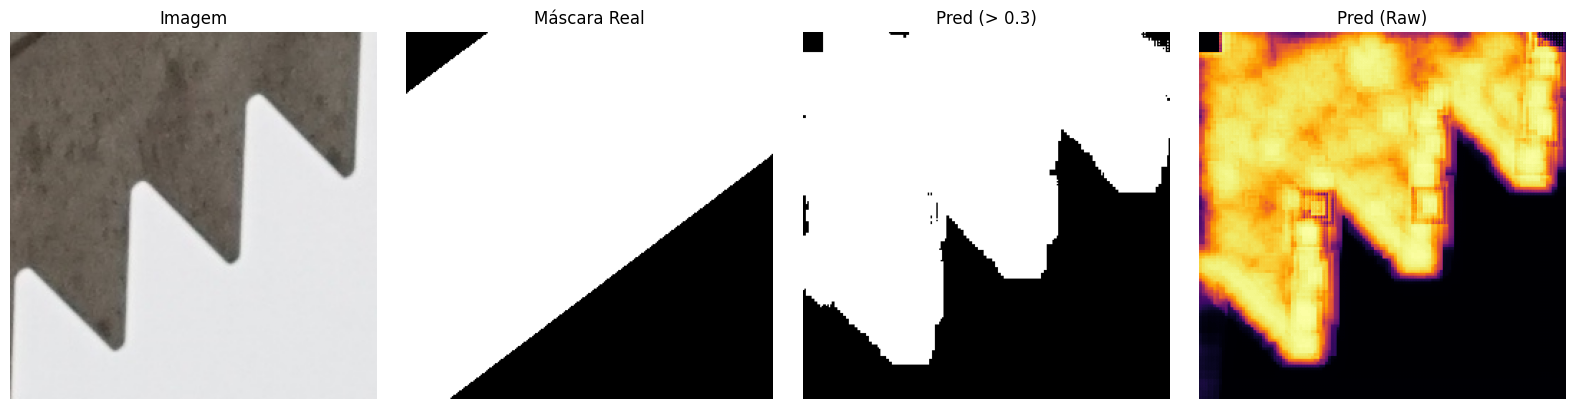

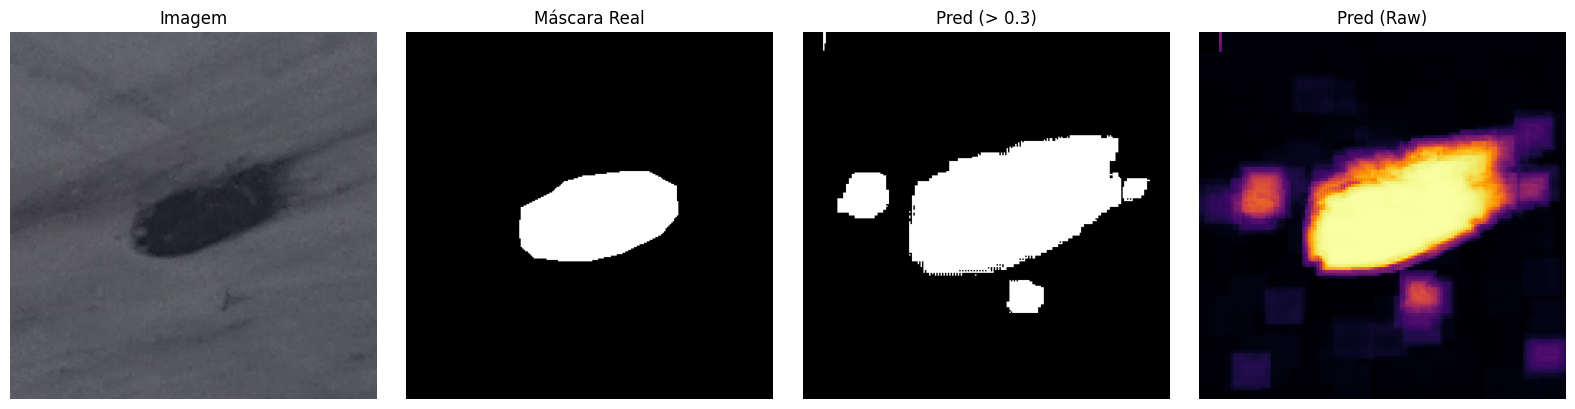

In [16]:

# 6. Execução
# -----------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image_dir = "D:/blade_30_dataset_crops/images"
    mask_dir = "D:/blade_30_dataset_crops/masks"

    dataset = CropSegmentationDataset(image_dir, mask_dir, img_size=256)
    model = YOLOv8_CBAM_Segmentation()

    train_on_crop_dataset(model, dataset, device=device, epochs=30, lr=1e-3)

    best_model = YOLOv8_CBAM_Segmentation().to(device)
    best_model.load_state_dict(torch.load("best_model_crops.pt", map_location=device))

    visualize_prediction(best_model, dataset, index=random.randint(0, len(dataset)-1), device=device, threshold=0.3)

    visualize_prediction(best_model, dataset, index=random.randint(0, len(dataset)-1), device=device)

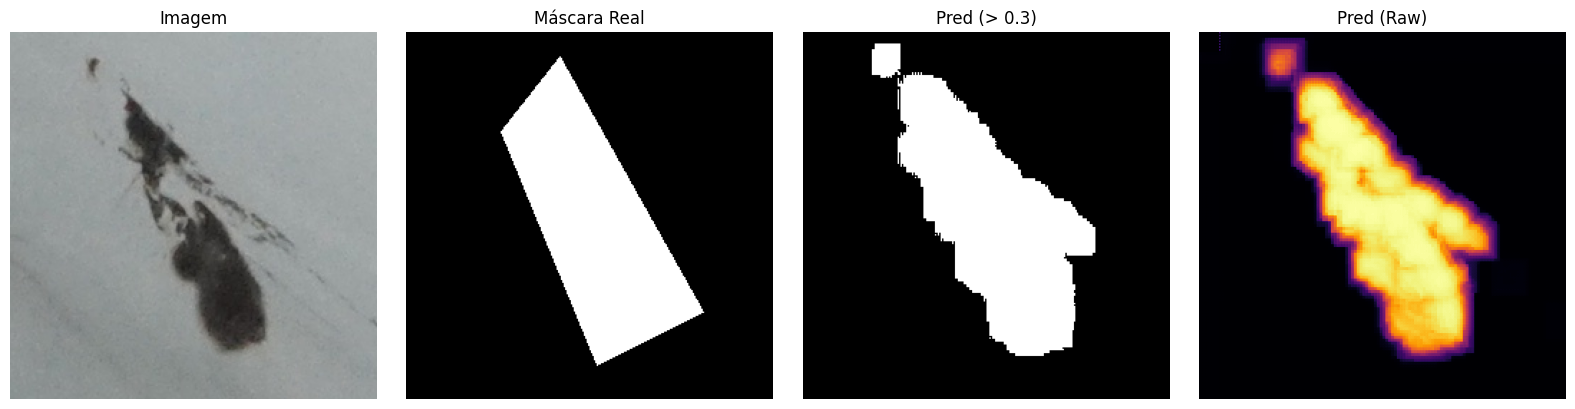

In [40]:
visualize_prediction(best_model, dataset, index=random.randint(0, len(dataset)-1), device=device)